# Opening the black box

In this lesson, we focus our attention on an increasingly important topic: As ML models are becoming increasingly complex and breaking ground in terms of performance, how do we still leave room for explanations that help us see beyond just the predictions.

We will use the [SHAP](https://github.com/slundberg/shap) library for this lab, and the [LIME](https://github.com/marcotcr/lime) library for the assignment.

Let's begin by loading the required libraries.

In [1]:
import pandas as pd
import numpy as np
np.random.seed(0)

from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
from sklearn.linear_model import LogisticRegression

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
matplotlib.rcParams['figure.figsize'] = [10, 7]

import shap
shap.initjs()

import warnings
warnings.filterwarnings('ignore')

### Data Preparation
For our dataset we will use a small part of the data collected by the investigative journalists at [The Markup](https://themarkup.org/show-your-work/2022/10/19/how-we-uncovered-disparities-in-internet-deals) on the pricing and availability of broadband internet. The full data set and label explanations are at this [GitHub repository](https://github.com/the-markup/investigation-isp).

In [2]:
isp = pd.read_csv('../data/seattle_centurylink_plans.csv')
isp.head()

,address_full,major_city,state,lat,lon,block_group,collection_datetime,provider,price,speed_down,...,speed_down_bins,redlining_grade,race_perc_non_white,race_quantile,median_household_income,income_dollars_below_median,income_level,ppl_per_sq_mile,n_providers,internet_perc_broadband
0,"4523 8TH AVE NE,SEATTLE,WA 98105,USA",seattle,WA,47.662003,-122.319830,530330052005,1650164667,CenturyLink,50.0,15.0,...,Slow (<25 Mbps),B,0.581002,least white,30286.0,66899.0,Low,9328.777184,3.0,0.732739
1,"4730 9TH AVE NE,SEATTLE,WA 98105,USA",seattle,WA,47.664034,-122.318082,530330052005,1650164663,CenturyLink,50.0,15.0,...,Slow (<25 Mbps),B,0.581002,least white,30286.0,66899.0,Low,9328.777184,3.0,0.732739
2,"4719 9TH AVE NE,SEATTLE,WA 98105,USA",seattle,WA,47.663705,-122.318562,530330052005,1650164664,CenturyLink,50.0,15.0,...,Slow (<25 Mbps),B,0.581002,least white,30286.0,66899.0,Low,9328.777184,3.0,0.732739
3,"4337 9TH AVE NE,SEATTLE,WA 98105,USA",seattle,WA,47.660588,-122.319064,530330052005,1650164663,CenturyLink,50.0,15.0,...,Slow (<25 Mbps),B,0.581002,least white,30286.0,66899.0,Low,9328.777184,3.0,0.732739
4,"4338 8TH AVE NE,SEATTLE,WA 98105,USA",seattle,WA,47.660572,-122.319460,530330052005,1650164676,CenturyLink,50.0,15.0,...,Slow (<25 Mbps),B,0.581002,least white,30286.0,66899.0,Low,9328.777184,3.0,0.732739


For our analysis we can ignore the geospatial and time dimensions to focus on what demographic and business environment factors impact the delivery of fast internet at affordable prices. When we plot internet value in megabits per second per monthly dollar we see a bimodal distribution:

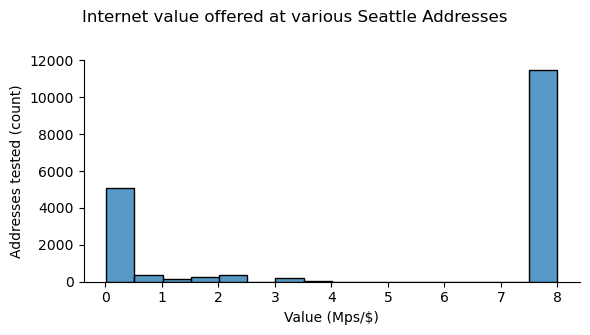

In [3]:
isp['value'] = (isp['speed_down'] + isp['speed_up']) / isp['price']

g = sns.displot(isp['value'], height = 3, aspect =2)
g.set_axis_labels('Value (Mps/$)', 'Addresses tested (count)')
g.fig.suptitle('Internet value offered at various Seattle Addresses', y = 1.1);

So we will define our target and do a quick EDA on our features

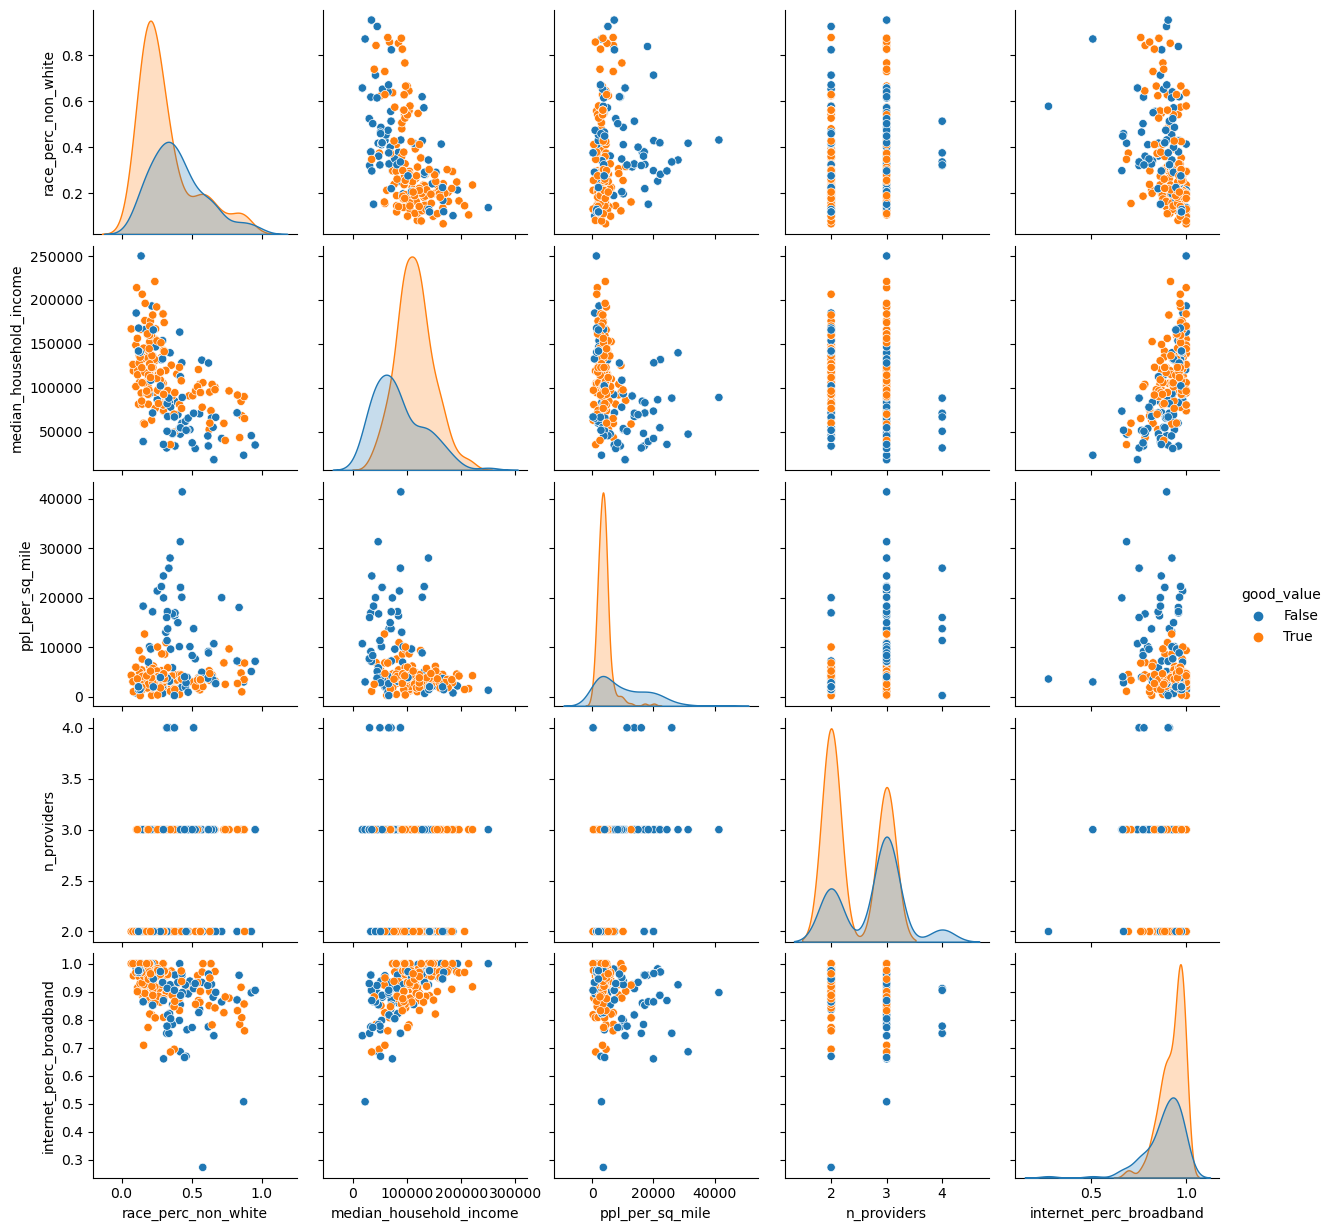

In [4]:
# create binary target
isp['good_value'] = isp['value'] > 6

# define numerical targets
num_cols = ['race_perc_non_white',  'median_household_income',
        'ppl_per_sq_mile', 'n_providers', 'internet_perc_broadband']

# quick EDA to see how numerical targets match with target
sns.pairplot(isp[num_cols + ['good_value']].sample(300), hue = 'good_value');

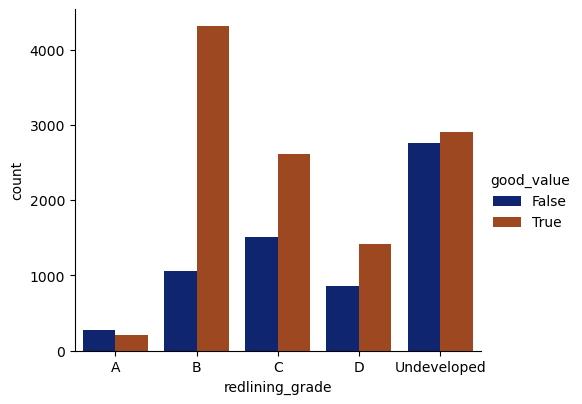

In [5]:
# areas that did not have a redlining score get their own category
cat_cols = ['redlining_grade']
isp['redlining_grade'] = isp['redlining_grade'].fillna('Undeveloped')

# How does quality broadband today line up with areas that were privileged (A, B),
# disadvantaged (C, D), and undeveloped 70+ years ago?
g = sns.catplot(data=isp, 
                kind="count",
                x="redlining_grade",
                hue="good_value", 
                order = ['A', 'B', 'C', 'D', 'Undeveloped'],
                palette="dark"
)
g.fig.set_size_inches(6, 4);

From our EDA we see some interesting patterns, but the data is not obviously linearly separable. If a black box model like a neural network or support vector classifier (SVC) does better that a linear, more explainable model like logistic regression, how can we understand the additional insights the model is making? 

We start with cleaning and splitting the data:

In [6]:
#drop unused columns and rows with missing data
drop = ['address_full', 'major_city', 'state', 'lat', 'lon', 'block_group',
       'collection_datetime', 'provider','speed_unit', 'package', 
       'race_quantile', 'speed_down_bins', 'income_level',  
       'technology', 'fastest_speed_down',
       'fastest_speed_price', 'income_dollars_below_median', 
       'speed_down', 'speed_up', 'price','value' ]
isp_no_nan = isp.drop(drop, axis = 1)
isp_no_nan = isp_no_nan.dropna(axis=0)

# we get a dramatic reduction in dataset size by only looking at one sample per neighborhood;
# taking the first target value for each neighborhood could be improved (i.e. taking the average)
isp_no_nan = isp_no_nan.drop_duplicates(num_cols + cat_cols)

# split data
X, y = isp_no_nan.drop('good_value', axis = 1), isp_no_nan['good_value']
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)
print('Training set size - X_train: {} '.format(X_train.shape))
print('Training set size - X_test: {} '.format(X_test.shape))

Training set size - X_train: (586, 6) 
Training set size - X_test: (147, 6) 


For an SVC model the values need to be numerical and in the same range, so we will use one hot encoding for categorical data and MinMaxScaler for numerical data so all values are between 0 and 1.

In [7]:
onehoter = OneHotEncoder(sparse_output= False)
onehoter.fit(X_train[cat_cols])
onehot_cols = onehoter.get_feature_names_out(cat_cols)
X_train_onehot = pd.DataFrame(onehoter.transform(X_train[cat_cols]), columns = onehot_cols)
X_test_onehot = pd.DataFrame(onehoter.transform(X_test[cat_cols]), columns = onehot_cols)

min_max = MinMaxScaler()
min_max.fit(X_train[num_cols])
X_train_norm = pd.DataFrame(min_max.transform(X_train[num_cols]), columns = num_cols)
X_test_norm = pd.DataFrame(min_max.transform(X_test[num_cols]), columns = num_cols)

X_train_featurized = X_train_onehot # add one-hot-encoded columns
X_test_featurized = X_test_onehot   # add one-hot-encoded columns
X_train_featurized[num_cols] = X_train_norm # add numeric columns
X_test_featurized[num_cols] = X_test_norm   # add numeric columns

del X_train_norm, X_test_norm, X_train_onehot, X_test_onehot, X_train, X, y
X_train_featurized.head()

,redlining_grade_A,redlining_grade_B,redlining_grade_C,redlining_grade_D,redlining_grade_Undeveloped,race_perc_non_white,median_household_income,ppl_per_sq_mile,n_providers,internet_perc_broadband
0,0.0,0.0,0.0,0.0,1.0,0.171702,0.382363,0.029331,0.0,0.924219
1,0.0,0.0,0.0,0.0,1.0,0.129858,0.503832,0.063396,0.0,0.941091
2,0.0,0.0,1.0,0.0,0.0,0.554218,0.376830,0.037082,0.0,0.885628
3,0.0,0.0,1.0,0.0,0.0,0.267868,0.360081,0.114570,0.5,1.000000
4,0.0,0.0,1.0,0.0,0.0,0.625466,0.279651,0.020630,0.5,0.797550


### Data modeling
Let's start by comparing a baseline logistic regression model with a non-linear SVC model

In [8]:
logreg = LogisticRegression(class_weight = 'balanced', random_state=0)
logreg.fit(X_train_featurized, Y_train)
predict_log = logreg.predict(X_test_featurized)

print(f"LogisticRegression performance measures\n{'-' * 50}")
print(f"{accuracy_score(predict_log, Y_test)=:.3f}")
print(f"{f1_score(predict_log, Y_test, average = 'weighted')=:.3f}")
print(f"confusion matrix:\n{confusion_matrix(predict_log, Y_test)}")

print(f"\nLogisticRegression coefficients\n{'-' * 50}")
coefs = logreg.coef_
for feature, coef in zip(X_train_featurized.columns, logreg.coef_[0]):
    print(f'{feature:<30} {coef:>6.2f}')

LogisticRegression performance measures
--------------------------------------------------
accuracy_score(predict_log, Y_test)=0.592
f1_score(predict_log, Y_test, average = 'weighted')=0.583
confusion matrix:
[[26 36]
 [24 61]]

LogisticRegression coefficients
--------------------------------------------------
redlining_grade_A               -0.60
redlining_grade_B                0.64
redlining_grade_C                0.43
redlining_grade_D                0.12
redlining_grade_Undeveloped     -0.59
race_perc_non_white              0.62
median_household_income          0.46
ppl_per_sq_mile                 -3.21
n_providers                     -1.46
internet_perc_broadband          1.12


This gives us a good baseline, and makes some intuitive sense. As the percentage of people with broadband goes up perhaps the ISPs must compete on value instead of availability. And areas that were not developed in the past may still have little infrastructure now. 

Other results are more counterintuitive. Sparsely populated areas can be more expensive to service with high speed internet, but increased density had the largest negative influence on affordable internet. And  more internet suppliers competing with each other making it less likely for consumers to get quality internet, perhaps suggesting less competition than would be expected.

Some features are encouraging, like  historically disadvantaged areas (redlined as C or D) and areas with current high minority group populations being slightly more likely to get quality internet. 

Now let's try our non-linear SVC model:

In [9]:
# Define the hyperparameter search space
hyperparameters = {
    'C': [0.9, 1, 1.1],
    'kernel': ['rbf', 'poly', 'sigmoid'],
    'degree' : [3,4],
    'gamma': ['scale', 'auto'],
}

# Create a new SVC object
svc = SVC(random_state=0)

# Perform the hyperparameter search using GridSearchCV
search = GridSearchCV(estimator=svc,
                      param_grid=hyperparameters,
                      cv=5, 
                      refit=False,
                      n_jobs=-1,
                      verbose=1,
                      )

# Fit the search to the training data
search.fit(X_train_featurized, Y_train)
search.best_params_

Fitting 5 folds for each of 36 candidates, totalling 180 fits


{'C': 1, 'degree': 4, 'gamma': 'scale', 'kernel': 'poly'}

In [10]:
# train the SVC model using the best hyperparameters
best_svc = SVC(**search.best_params_, 
               probability=True,  # this is slower, but needed for SHAP
               random_state=0)

best_svc.fit(X_train_featurized, Y_train)
predict_svc = best_svc.predict(X_test_featurized)

print(f"SVC performance measures\n{'-' * 50}")
print(f"{accuracy_score(predict_svc, Y_test)=:.3f}")
print(f"{f1_score(predict_svc, Y_test, average = 'weighted')=:.3f}")
print(f"confusion matrix:\n{confusion_matrix(predict_svc, Y_test)}")

SVC performance measures
--------------------------------------------------
accuracy_score(predict_svc, Y_test)=0.721
f1_score(predict_svc, Y_test, average = 'weighted')=0.738
confusion matrix:
[[21 12]
 [29 85]]


The good news is that the SVC does beat the baseline mode. The problem is that unlike logistic regression, there is no easy way to explain the model. This is where SHAP values can help.

There are multiple explainers offered by `SHAP`: if the black-box model we use is tree-based, we can use `TreeExplainer()` to boost runtime (it implements optimizations specific to tree-based models). Similarly, there is a `DeepExplainer()` for neural network models. For all other kinds of algorithms, such as SVMs or KNNs, we use `KernelExplainer()`. 

Calculating SHAP values can take a lot of time. The default data parameter simulates a missing value using every possible value in the dataset; we can speed this up by supplying a kmeans clustered set of representative values. The calculation of SHAP values uses the parameter nsamples, the "number of times to re-evaluate the model when explaining each prediction. The “auto” setting uses nsamples = 2 * X.shape[1] + 2048." We will use far fewer samples for the sake of time, but you can try running with a larger sample overnight to see if the results are similar.

In [11]:
def get_shap_values(model, X_train, X_test, kmeans=None, nsamples=5, l1_reg = "num_features(6)"):
    '''Compute SHAP values, with option to use a sampling of the data instead of all the data'''
    if kmeans:
        X_train = shap.kmeans(X_train, kmeans)
    explainer = shap.KernelExplainer(model = model.predict_proba, data = X_train, link = "logit")
    return explainer, explainer.shap_values(X = X_test, nsamples = nsamples, l1_reg = l1_reg)

explainer, shap_values = get_shap_values(best_svc, 
                              X_train_featurized, 
                              X_test_featurized, 
                              kmeans=80, #chooses representative feature values to test, simplifies the computation
                              nsamples=200, # more sampling will make the shap values more accurate, but more compute 
                              )

  0%|          | 0/147 [00:00<?, ?it/s]

If we examine the values we obtained, we can see that two sets of SHAP values were returned to us, but we only need 1. The multiple sets are useful in the context of multi-class classification, but not for binary classification.

In [12]:
# For each test prediction there are [number of classification targets] number of arrays of shap values
# with each array being [number of features in X_train/X_test] long, all summing to 0
assert(len(shap_values[0]) == X_test_featurized.shape[0])

sum([int(sum(shap_values[0][i] + shap_values[1][i])) for i in range(X_test_featurized.shape[0])])

0

So how do we access the SHAP values? Recall that we get a SHAP value for each instance and feature combination, in other words one for each row and column from the featurized data. Since the output is a `numpy` array, it's better to use `pandas` and display it as a `DataFrame`. Here are the first few examples from the test data.

In [13]:
# use shap_values[1], positive shap value predicts positive prediction for the 
# target, high quality internet access
df_shap = pd.DataFrame(shap_values[1], columns = X_test_featurized.columns)
df_shap.head()

,redlining_grade_A,redlining_grade_B,redlining_grade_C,redlining_grade_D,redlining_grade_Undeveloped,race_perc_non_white,median_household_income,ppl_per_sq_mile,n_providers,internet_perc_broadband
0,0.000000,-0.366690,-0.304693,-0.089949,0.546114,0.000000,0.000000,0.106020,0.595147,0.000000
1,0.000000,-0.354617,-0.088325,0.000000,0.000000,-0.053961,0.000000,-0.413861,-0.041605,-0.059249
2,0.000000,-0.287894,-0.198385,0.000000,0.195106,0.000000,-0.168776,0.000000,0.470639,-0.109627
3,-0.051057,0.676048,-0.062264,0.000000,0.000000,0.000000,-0.393047,-0.087498,-0.142631,0.000000
4,0.000000,1.041588,-0.317935,-0.084417,-0.244772,-0.052766,-0.079673,0.000000,0.000000,0.000000


The higher the SHAP value the higher the probability of being a location with access to quality affordable internet. A positive SHAP value corresponds to an increase, and a negative value to a decrease in the probability. Here's an example of SHAP values for one instance along with the raw and normalized feature values:

In [14]:
IDX = 0

raw_instance = pd.Series(X_test.iloc[IDX, :], name = 'raw')
norm_instance = pd.Series(X_test_featurized.iloc[IDX, :], name = 'norm').to_frame()
shap_instance = pd.Series(df_shap.iloc[IDX, :], name = 'shap')
combined = norm_instance.join(raw_instance)
combined = combined.join(shap_instance)
combined.sort_values(by = 'shap', key = abs, ascending = False)

,norm,raw,shap
n_providers,0.000000,2.0,0.595147
redlining_grade_Undeveloped,1.000000,NaN,0.546114
redlining_grade_B,0.000000,NaN,-0.366690
redlining_grade_C,0.000000,NaN,-0.304693
ppl_per_sq_mile,0.035392,2188.914839,0.106020
redlining_grade_D,0.000000,NaN,-0.089949
redlining_grade_A,0.000000,NaN,0.000000
race_perc_non_white,0.321340,0.305939,0.000000
median_household_income,0.580212,151528.0,0.000000
internet_perc_broadband,0.864027,0.930841,0.000000


We can run the following cell to visualize the SHAP values for that instance.

In [15]:
predictions = best_svc.predict_proba(X_test_featurized)[:, 1]
print(f'Prediction for row {IDX} in X_test: {predictions[IDX]:.2f}')

shap.force_plot(explainer.expected_value[1], 
                shap_values[1][IDX,:], 
                X_test_featurized.iloc[IDX,:], 
                link = "logit")

Prediction for row 0 in X_test: 0.72


So if for example we evaluate `sum(instance) - instance['median_household_income']`, we get the marginal contribution of all features minus `median_household_income` to the probability of being offered quality internet access.

We can see the direct relationship between SHAP values for each instance (summed across features) and the associated probability in the plot below. This plot can help us translate differences in SHAP values to differences in probabilities.

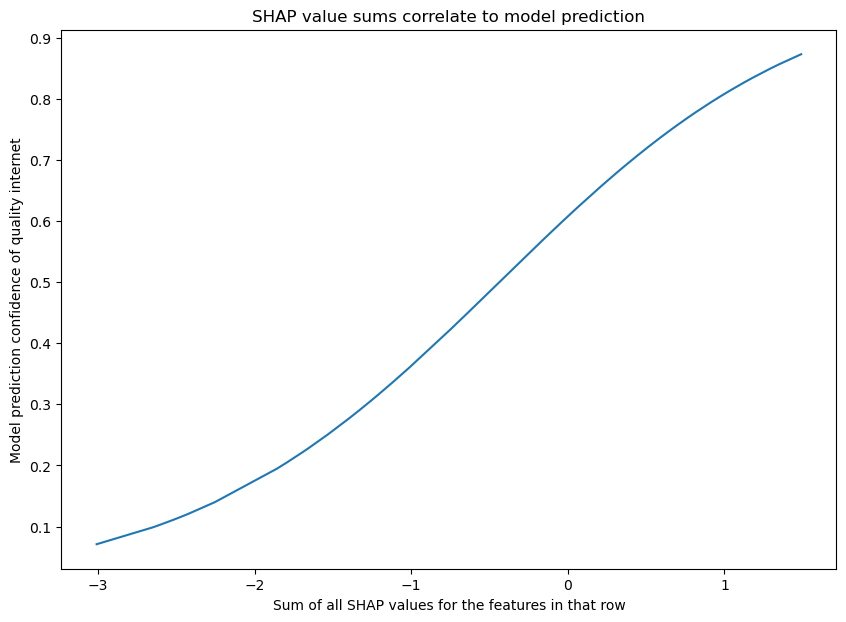

In [16]:
predictions = best_svc.predict_proba(X_test_featurized)[:, 1]
g = sns.lineplot(x = shap_values[1].sum(axis = 1), y = predictions)
g.set(ylabel = 'Model prediction confidence of quality internet',
      xlabel = 'Sum of all SHAP values for the features in that row',
      title = 'SHAP value sums correlate to model prediction');
             

What if we wanted to see these shap values across the whole data? Then we can turn to the plot below. The plot is generated by finding the above plot for all rows of the test data, rotating them 90 degrees and stacking them horizontally. Finally, by default the plot is sorted by similarity, so rows with similar SHAP values are placed next to each other. However, as the plot is interactive, we can reorder the data based on other features.

In [17]:
shap.force_plot(explainer.expected_value[1], shap_values[1], X_test_featurized, link = 'logit')

A summary dot plot shows how the value of each feature pushes the model towards a prediction. 
- The color is the value of the feature. For a boolean column like `redlining_grade_B` (historically upper middle class neighborhoods) having this attribute (red) strongly pushes the model towards predicting you will have fast, affordable internet. Population density (`ppl_per_sq_mile`) has a reversed distribution, where high density areas have worse internet access, as the logistic regression suggested.
- If all the features split like those two, then logistic regression would probably score similar accuracy. But look at features like `median_household_income` and the formerly undeveloped neighborhoods (`redlining_grade_Undeveloped`). Being formerly undeveloped can be positive or negative for the model, depending on current demographics. And for household income it seems very low and very high incomes predict low access to cheap internet, while the purple middle income areas predict access to quality internet. Such non linear features can be captured by models like SVCs.

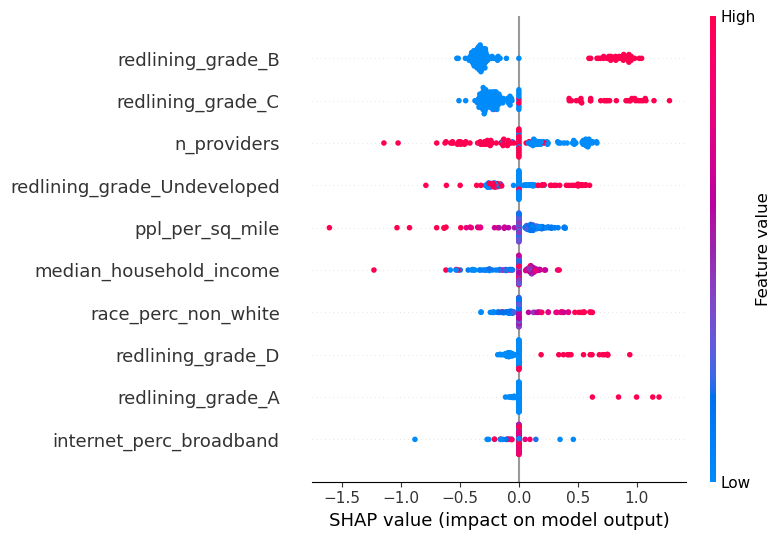

In [18]:
shap.summary_plot(shap_values[1], X_test_featurized)

To study the effect of features individually, we can look at feature dependence plots like the one below showing the curving relationship between income and affordable internet noted above. 

The feature dependence plot automatically includes a third feature (shown on the right vertical axis), which is the one that your feature most interacts with. So as a bonus we can also look for interaction by paying attention to how the colors are spread. Because this can change based on the random variation in SHAP simulations, we can specify the interaction of interest using the interaction_index parameter. In this case, `median_household_income` and `ppl_per_square_mile` seem to interact, with wealthier areas generally being less dense.

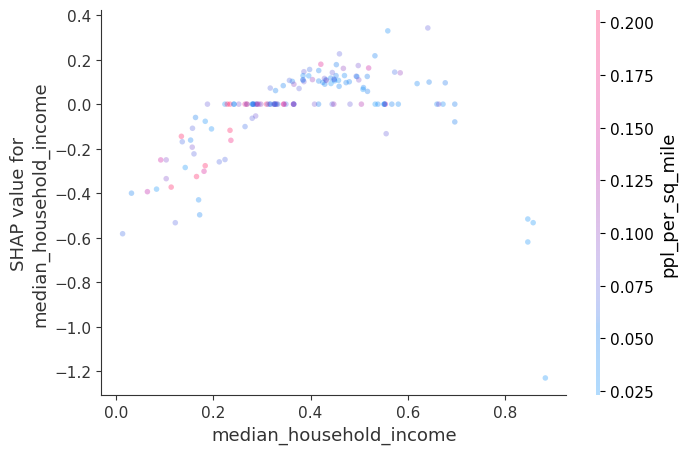

In [19]:
shap.dependence_plot("median_household_income", 
                     shap_values[1], 
                     X_test_featurized, 
                     interaction_index = 'ppl_per_sq_mile',
                     x_jitter=.1, 
                     alpha=.3)

In the below plot, we can see that areas with high `ppl_per_sq_mile` tend to get worse internet offers, even though the level of ISP competition indicated by `n_providers` is high.

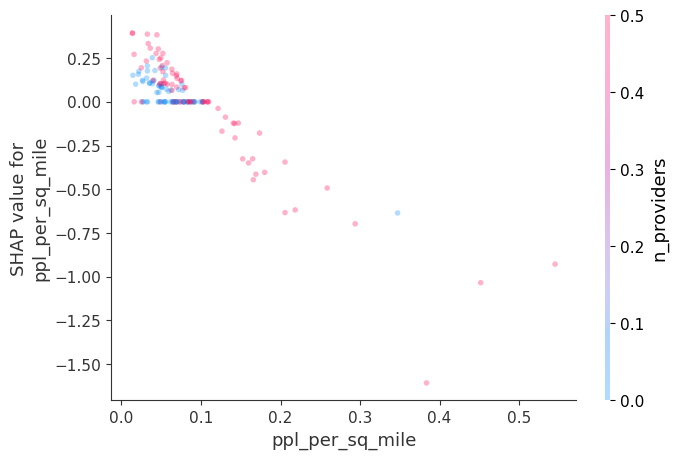

In [20]:
shap.dependence_plot("ppl_per_sq_mile", 
                     shap_values[1], 
                     X_test_featurized,
                     interaction_index = 'n_providers',
                     x_jitter=.1, 
                     alpha=.3)

There is a lot more to explore, but we will stop here and give you a chance to explore this data from another angle for the assignment. Because the topic of explainability has a lot of interest, we recommend that you keep an eye on the libraries and what updates come with every release. 